In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np
from scipy.stats import hypergeom

/tmp/ipykernel_91360/3312538261.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['GD','w/o GD'],fontsize=12)


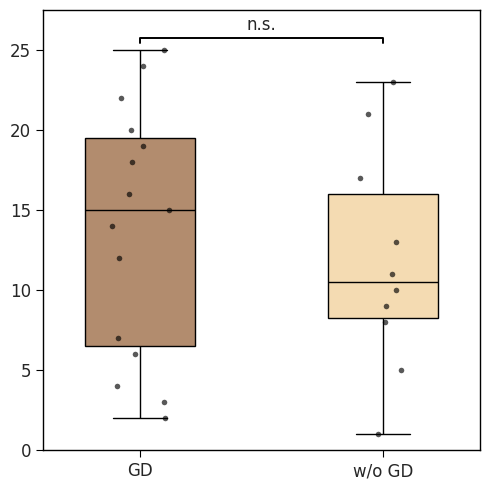

In [7]:
df = pd.read_csv('cbdir_rank.csv')
df["GD"] = df["GD"].astype(str)
df["GD"] = pd.Categorical(df["GD"], categories=["1", "0"], ordered=True)

plt.figure(figsize=(5, 5))
sns.set_style("white")

group_colors = {
    '1':'#b28c6e',
    '0':'#F4DBB2'
}

ax = sns.boxplot(
    x="GD",
    y="rank",
    data=df,
    width=0.45,
    linewidth=1.6,
    showfliers=False,
    palette=group_colors,
    saturation=1,
    hue="GD",
    legend=False,
    boxprops={'alpha': 1, 'edgecolor': 'black', 'linewidth': 1.0}, 
    medianprops={'color': 'black', 'linewidth': 1.0},
    whiskerprops={'color': 'black', 'linewidth': 1.0},
    capprops={'color': 'black', 'linewidth': 1.0},
)

sns.stripplot(
    x="GD",
    y="rank",
    data=df,
    color="black",
    size=4,
    jitter=0.12,
    alpha=0.65
)

plt.xlabel("", fontsize=13)
plt.ylabel("", fontsize=13)
plt.title("", fontsize=14)

group1 = df[df["GD"] == "1"]["rank"]
group0 = df[df["GD"] == "0"]["rank"]

stat, p = mannwhitneyu(group1, group0, alternative="two-sided")
ax.set_xticklabels(['GD','w/o GD'],fontsize=12)
lims = [0, 27]
plt.ylim([0.0,27.5])
y_ticks = np.arange(np.floor(lims[0]), np.ceil(lims[1]) + 1, 5)
plt.yticks(y_ticks, fontsize=12)

def p_to_star(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return "n.s."

star = p_to_star(p)

y_max = df["rank"].max()
line_y = y_max + (y_max * 0.03)
text_y = y_max + (y_max * 0.05)

x1, x2 = 0, 1

plt.plot(
    [x1, x1, x2, x2],
    [line_y - 0.3, line_y, line_y, line_y - 0.3],
    lw=1.4,
    color="black"
)

plt.text((x1 + x2) / 2, text_y, star, ha="center", fontsize=12)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)

ax.set_xlim(-0.4, 1.4)

plt.tight_layout()
plt.savefig(f"boxplot_cbdir.png",bbox_inches="tight", dpi=300)
plt.show()


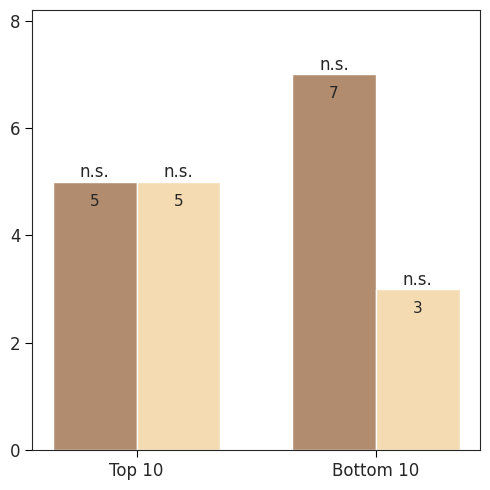

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

top_k = 10

is_gd = (df["GD"] == "1")
is_notgd = (df["GD"] == "0")

df_top = df.nsmallest(top_k, "rank")
gd_top = is_gd.loc[df_top.index].sum()
notgd_top = is_notgd.loc[df_top.index].sum()

df_bottom = df.nlargest(top_k, "rank")
gd_bottom = is_gd.loc[df_bottom.index].sum()
notgd_bottom = is_notgd.loc[df_bottom.index].sum()

def hyper_p(df, group_mask, df_sub):
    N = len(df)
    K = group_mask.sum()
    n = len(df_sub)
    k = group_mask.loc[df_sub.index].sum()
    return hypergeom.sf(k - 1, N, K, n)

p_top_gd = hyper_p(df, is_gd, df_top)
p_top_notgd = hyper_p(df, is_notgd, df_top)
p_bottom_gd = hyper_p(df, is_gd, df_bottom)
p_bottom_notgd = hyper_p(df, is_notgd, df_bottom)

def p_to_star(p):
    if p < 0.01: return "***"
    elif p < 0.05: return "**"
    elif p < 0.1: return "*"
    return "n.s."

stars_gd = [
    p_to_star(p_top_gd),      # For Top 10 GD
    p_to_star(p_bottom_gd)    # For Bottom 10 GD
]

stars_notgd = [
    p_to_star(p_top_notgd),   # For Top 10 non-GD
    p_to_star(p_bottom_notgd) # For Bottom 10 non-GD
]

# ============================
# 2. Prepare Plotting Data
# ============================

labels = ["Top 10", "Bottom 10"]
gd_counts = [gd_top, gd_bottom]
notgd_counts = [notgd_top, notgd_bottom]

x = np.arange(len(labels))       
width = 0.35

# ============================
# 3. Plotting
# ============================

plt.figure(figsize=(5, 5))


bar1 = plt.bar(x - width/2, gd_counts, width, label="GD", color='#b28c6e')

bar2 = plt.bar(x + width/2, notgd_counts, width, label="non-GD", color='#F4DBB2')


def annotate_bar(bar, star_text):
    """Add count numbers and significance stars to bars"""
    for rect, star in zip(bar, star_text):
        height = rect.get_height()

        # Count number
        plt.text(
            rect.get_x() + rect.get_width() / 2,
            height - 0.5,
            f"{int(height)}",
            ha="center", va="bottom", fontsize=11
        )

        # Star (slightly higher)
        plt.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.01,
            star,
            ha="center", va="bottom", fontsize=12
        )

# Add annotations separately
annotate_bar(bar1, stars_gd)
annotate_bar(bar2, stars_notgd)

# ============================

plt.xticks(x, labels, fontsize=12)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)
# plt.legend()

y_ticks = np.arange(0, 9, 2)
plt.yticks(y_ticks, fontsize=12)
plt.ylim(0.0, 8 + 0.2)

plt.tight_layout()
plt.savefig(f"cbdir_enrich.png", bbox_inches="tight", dpi=300)
plt.show()

/tmp/ipykernel_91360/2912593396.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['GD', 'w/o GD'], fontsize=12)


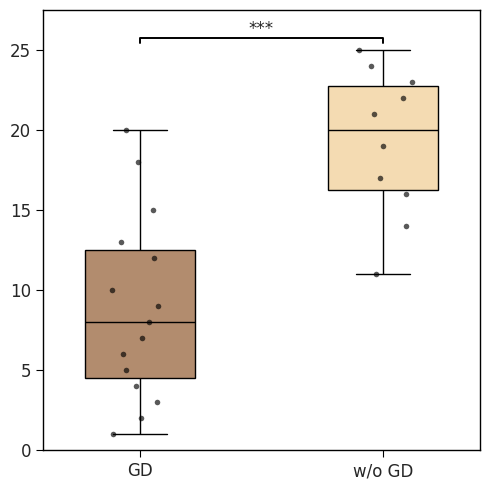

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# 1. Read data
df = pd.read_csv('icvcoh_rank.csv')
df["GD"] = df["GD"].astype(str)
df["GD"] = pd.Categorical(df["GD"], categories=["1", "0"], ordered=True)

# 2. Plotting
plt.figure(figsize=(5, 5))
sns.set_style("white")

group_colors = {
    '1': '#b28c6e',
    '0': '#F4DBB2'
}

ax = sns.boxplot(
    x="GD",
    y="rank",
    data=df,
    width=0.45,
    linewidth=1.6,
    showfliers=False,
    palette=group_colors,
    saturation=1,
    hue="GD",             # Suggest adding hue to avoid warnings in newer seaborn versions
    legend=False,         # Hide legend
    boxprops={'alpha': 1, 'edgecolor': 'black', 'linewidth': 1.0}, 
    medianprops={'color': 'black', 'linewidth': 1.0},
    whiskerprops={'color': 'black', 'linewidth': 1.0},
    capprops={'color': 'black', 'linewidth': 1.0},
)

# Keep strip plot points closer to the box to avoid excessive spread
sns.stripplot(
    x="GD",
    y="rank",
    data=df,
    color="black",
    size=4,
    jitter=0.12,         # Control jitter to prevent points from spreading too far
    alpha=0.65
)

plt.xlabel("", fontsize=13)
plt.ylabel("", fontsize=13)
plt.title("", fontsize=14)

# 3. Mann-Whitney U Test
group1 = df[df["GD"] == "1"]["rank"]
group0 = df[df["GD"] == "0"]["rank"]

stat, p = mannwhitneyu(group1, group0, alternative="two-sided")
ax.set_xticklabels(['GD', 'w/o GD'], fontsize=12)

lims = [0, 27]
plt.ylim([0.0, 27.5])
y_ticks = np.arange(np.floor(lims[0]), np.ceil(lims[1]) + 1, 5)
plt.yticks(y_ticks, fontsize=12)

# 4. Star mapping logic
def p_to_star(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return "n.s."

star = p_to_star(p)

# 5. Significance annotation
y_max = df["rank"].max()
line_y = y_max + (y_max * 0.03)
text_y = y_max + (y_max * 0.04)

x1, x2 = 0, 1

plt.plot(
    [x1, x1, x2, x2],
    [line_y - 0.3, line_y, line_y, line_y - 0.3],
    lw=1.4,
    color="black"
)

plt.text((x1 + x2) / 2, text_y, star, ha="center", fontsize=12)

# 6. Customize axes
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)

# Control spacing between groups to keep them close
ax.set_xlim(-0.4, 1.4)

plt.tight_layout()
plt.savefig(f"boxplot_icvcoh.png", bbox_inches="tight", dpi=300)
plt.show()

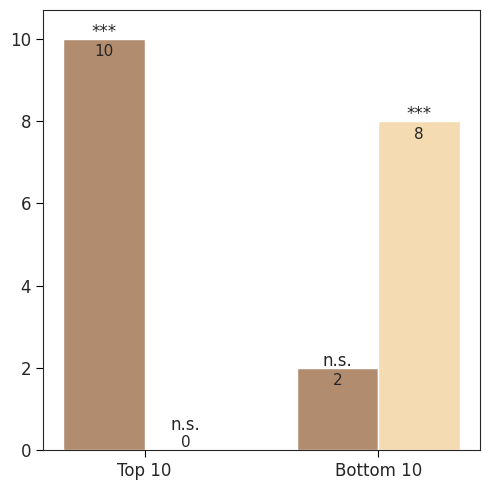

In [10]:
# ============================
# 1. Calculate Counts and Hypergeometric Test
# ============================

top_k = 10

# Define masks for "GD=1" and "non-GD=0"
is_gd = (df["GD"] == "1")
is_notgd = (df["GD"] == "0")

# Top 10
df_top = df.nsmallest(top_k, "rank")
gd_top = is_gd.loc[df_top.index].sum()
notgd_top = is_notgd.loc[df_top.index].sum()

# Bottom 10
df_bottom = df.nlargest(top_k, "rank")
gd_bottom = is_gd.loc[df_bottom.index].sum()
notgd_bottom = is_notgd.loc[df_bottom.index].sum()

# --- Hypergeometric Test Function ---
def hyper_p(df, group_mask, df_sub):
    N = len(df)
    K = group_mask.sum()
    n = len(df_sub)
    k = group_mask.loc[df_sub.index].sum()
    return hypergeom.sf(k - 1, N, K, n)

# P-values for each bar
p_top_gd = hyper_p(df, is_gd, df_top)
p_top_notgd = hyper_p(df, is_notgd, df_top)
p_bottom_gd = hyper_p(df, is_gd, df_bottom)
p_bottom_notgd = hyper_p(df, is_notgd, df_bottom)

# --- Significance Stars ---
def p_to_star(p):
    if p < 0.01: return "***"
    elif p < 0.05: return "**"
    elif p < 0.1: return "*"
    return "n.s."

# Organize stars by Bar Group (GD vs non-GD) so they match the bar objects below
# bar1 will hold GD data (Top and Bottom)
stars_gd = [
    p_to_star(p_top_gd),      # For Top 10 GD
    p_to_star(p_bottom_gd)    # For Bottom 10 GD
]

# bar2 will hold non-GD data (Top and Bottom)
stars_notgd = [
    p_to_star(p_top_notgd),   # For Top 10 non-GD
    p_to_star(p_bottom_notgd) # For Bottom 10 non-GD
]

# ============================
# 2. Prepare Plotting Data
# ============================

labels = ["Top 10", "Bottom 10"]
gd_counts = [gd_top, gd_bottom]
notgd_counts = [notgd_top, notgd_bottom]

x = np.arange(len(labels))       # [0, 1]
width = 0.35                     # bar width

# ============================
# 3. Start Plotting
# ============================

plt.figure(figsize=(5, 5))

# bar1: GD bars for Top and Bottom
bar1 = plt.bar(x - width/2, gd_counts, width, label="GD", color='#b28c6e')
# bar2: non-GD bars for Top and Bottom
bar2 = plt.bar(x + width/2, notgd_counts, width, label="non-GD", color='#F4DBB2')

# ============================
# 4. Add Stars + Numbers to Each Bar
# ============================

def annotate_bar(bar, star_text):
    """Add count numbers and significance stars to bars"""
    for rect, star in zip(bar, star_text):
        height = rect.get_height()
        
        if height == 0:
            # Number (count) at 0
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                height,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=11
            )
            # Star (higher up)
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                height + 0.4,
                star,
                ha="center", va="bottom", fontsize=12
            )
        else:
            # Number (count) inside the bar
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                height - 0.5,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=11
            )
            # Star (slightly above the bar)
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                height - 0.05,
                star,
                ha="center", va="bottom", fontsize=12
            )

# Add annotations separately
annotate_bar(bar1, stars_gd)      # Apply GD stars to GD bars
annotate_bar(bar2, stars_notgd)   # Apply non-GD stars to non-GD bars

# ============================

plt.xticks(x, labels, fontsize=12)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)
# plt.legend()

y_ticks = np.arange(0, 11.5, 2)
plt.yticks(y_ticks, fontsize=12)
plt.ylim(0, 10.5 + 0.2)

plt.tight_layout()
plt.savefig(f"icvcoh_enrich.png", bbox_inches="tight", dpi=300)
plt.show()